#LLAMA + DUCKDB + RARE


In [19]:
!pip install -q \
    duckdb \
    sentence-transformers \
    llama-cpp-python==0.2.24 \
    tqdm \
    matplotlib \
    fpdf \
    PyMuPDF \
    PyPDF2


In [20]:
import os
import re
import uuid
import duckdb
import numpy as np
from tqdm import tqdm
from io import BytesIO
from IPython.display import display, HTML
from fpdf import FPDF
from PyPDF2 import PdfReader
from google.colab import files
import matplotlib.pyplot as plt


In [21]:
from sentence_transformers import SentenceTransformer

def init_embedding_model():
    model_path = "/content/models/all-MiniLM-L6-v2"
    os.makedirs("/content/models", exist_ok=True)

    if os.path.exists(model_path):
        print("🔁 Loading MiniLM model from cache...")
        return SentenceTransformer(model_path)
    else:
        print("⬇️ Downloading MiniLM embedding model...")
        model = SentenceTransformer("all-MiniLM-L6-v2")
        model.save(model_path)
        return model


In [22]:
embedding_model = init_embedding_model()


🔁 Loading MiniLM model from cache...


ValueError: Unrecognized model in /content/models/all-MiniLM-L6-v2. Should have a `model_type` key in its config.json, or contain one of the following strings in its name: albert, align, altclip, aria, aria_text, audio-spectrogram-transformer, autoformer, aya_vision, bamba, bark, bart, beit, bert, bert-generation, big_bird, bigbird_pegasus, biogpt, bit, blenderbot, blenderbot-small, blip, blip-2, bloom, bridgetower, bros, camembert, canine, chameleon, chinese_clip, chinese_clip_vision_model, clap, clip, clip_text_model, clip_vision_model, clipseg, clvp, code_llama, codegen, cohere, cohere2, colpali, conditional_detr, convbert, convnext, convnextv2, cpmant, ctrl, cvt, dab-detr, dac, data2vec-audio, data2vec-text, data2vec-vision, dbrx, deberta, deberta-v2, decision_transformer, deepseek_v3, deformable_detr, deit, depth_anything, depth_pro, deta, detr, diffllama, dinat, dinov2, dinov2_with_registers, distilbert, donut-swin, dpr, dpt, efficientformer, efficientnet, electra, emu3, encodec, encoder-decoder, ernie, ernie_m, esm, falcon, falcon_mamba, fastspeech2_conformer, flaubert, flava, fnet, focalnet, fsmt, funnel, fuyu, gemma, gemma2, gemma3, gemma3_text, git, glm, glm4, glpn, got_ocr2, gpt-sw3, gpt2, gpt_bigcode, gpt_neo, gpt_neox, gpt_neox_japanese, gptj, gptsan-japanese, granite, granitemoe, granitemoeshared, granitevision, graphormer, grounding-dino, groupvit, helium, hiera, hubert, ibert, idefics, idefics2, idefics3, idefics3_vision, ijepa, imagegpt, informer, instructblip, instructblipvideo, jamba, jetmoe, jukebox, kosmos-2, layoutlm, layoutlmv2, layoutlmv3, led, levit, lilt, llama, llama4, llama4_text, llava, llava_next, llava_next_video, llava_onevision, longformer, longt5, luke, lxmert, m2m_100, mamba, mamba2, marian, markuplm, mask2former, maskformer, maskformer-swin, mbart, mctct, mega, megatron-bert, mgp-str, mimi, mistral, mistral3, mixtral, mllama, mobilebert, mobilenet_v1, mobilenet_v2, mobilevit, mobilevitv2, modernbert, moonshine, moshi, mpnet, mpt, mra, mt5, musicgen, musicgen_melody, mvp, nat, nemotron, nezha, nllb-moe, nougat, nystromformer, olmo, olmo2, olmoe, omdet-turbo, oneformer, open-llama, openai-gpt, opt, owlv2, owlvit, paligemma, patchtsmixer, patchtst, pegasus, pegasus_x, perceiver, persimmon, phi, phi3, phi4_multimodal, phimoe, pix2struct, pixtral, plbart, poolformer, pop2piano, prompt_depth_anything, prophetnet, pvt, pvt_v2, qdqbert, qwen2, qwen2_5_vl, qwen2_audio, qwen2_audio_encoder, qwen2_moe, qwen2_vl, qwen3, qwen3_moe, rag, realm, recurrent_gemma, reformer, regnet, rembert, resnet, retribert, roberta, roberta-prelayernorm, roc_bert, roformer, rt_detr, rt_detr_resnet, rt_detr_v2, rwkv, sam, sam_vision_model, seamless_m4t, seamless_m4t_v2, segformer, seggpt, sew, sew-d, shieldgemma2, siglip, siglip2, siglip_vision_model, smolvlm, smolvlm_vision, speech-encoder-decoder, speech_to_text, speech_to_text_2, speecht5, splinter, squeezebert, stablelm, starcoder2, superglue, superpoint, swiftformer, swin, swin2sr, swinv2, switch_transformers, t5, table-transformer, tapas, textnet, time_series_transformer, timesformer, timm_backbone, timm_wrapper, trajectory_transformer, transfo-xl, trocr, tvlt, tvp, udop, umt5, unispeech, unispeech-sat, univnet, upernet, van, video_llava, videomae, vilt, vipllava, vision-encoder-decoder, vision-text-dual-encoder, visual_bert, vit, vit_hybrid, vit_mae, vit_msn, vitdet, vitmatte, vitpose, vitpose_backbone, vits, vivit, wav2vec2, wav2vec2-bert, wav2vec2-conformer, wavlm, whisper, xclip, xglm, xlm, xlm-prophetnet, xlm-roberta, xlm-roberta-xl, xlnet, xmod, yolos, yoso, zamba, zamba2, zoedepth

In [23]:
def download_llama_model():
    os.makedirs("/content/models", exist_ok=True)
    model_path = "/content/models/llama-2-7b-chat.Q4_K_M.gguf"

    if not os.path.exists(model_path):
        print("⬇️ Downloading LLaMA 2 GGUF model...")
        !wget -q https://huggingface.co/TheBloke/Llama-2-7B-Chat-GGUF/resolve/main/llama-2-7b-chat.Q4_K_M.gguf -O {model_path}
        print("✅ Download complete.")
    else:
        print("✅ LLaMA model already exists.")

    return model_path


In [24]:
llama_model_path = download_llama_model()


✅ LLaMA model already exists.


**CPU**

In [7]:
from llama_cpp import Llama

def load_llama_cpu_model():
    model_path = "/content/models/llama-2-7b-chat.Q4_K_M.gguf"
    print("🧠 Loading LLaMA model on CPU...")
    return Llama(
        model_path=model_path,
        n_ctx=2048,
        n_threads=4,
        n_gpu_layers=0  # CPU only
    )


In [8]:
llm = load_llama_cpu_model()


🧠 Loading LLaMA model on CPU...


AVX = 1 | AVX2 = 1 | AVX512 = 1 | AVX512_VBMI = 0 | AVX512_VNNI = 0 | FMA = 1 | NEON = 0 | ARM_FMA = 0 | F16C = 1 | FP16_VA = 0 | WASM_SIMD = 0 | BLAS = 0 | SSE3 = 1 | SSSE3 = 1 | VSX = 0 | 


In [9]:
class DuckDBStorage:
    """Handles all DB operations using DuckDB (in-memory or on-disk)"""

    def __init__(self, db_path=":memory:"):
        self.conn = duckdb.connect(db_path)
        self._create_tables()

    def _create_tables(self):
        self.conn.execute("""
        CREATE TABLE IF NOT EXISTS learning_materials (
            id VARCHAR PRIMARY KEY,
            title TEXT,
            content TEXT,
            topic TEXT,
            difficulty INTEGER
        )
        """)
        self.conn.execute("""
        CREATE TABLE IF NOT EXISTS embeddings (
            id VARCHAR PRIMARY KEY,
            material_id VARCHAR,
            chunk_start INTEGER,
            chunk_end INTEGER,
            chunk_text TEXT,
            embedding FLOAT[]
        )
        """)
        print("✅ Database tables created.")

    def add_learning_material(self, title, content, topic, difficulty):
        material_id = str(uuid.uuid4())
        try:
            self.conn.execute("""
                INSERT INTO learning_materials (id, title, content, topic, difficulty)
                VALUES (?, ?, ?, ?, ?)
            """, (material_id, title, content, topic, difficulty))
            return material_id
        except Exception as e:
            print(f"❌ Error adding material: {e}")
            return None

    def get_learning_material(self, material_id):
        try:
            return self.conn.execute("""
                SELECT id, title, content, topic, difficulty
                FROM learning_materials
                WHERE id = ?
            """, [material_id]).fetchone()
        except Exception as e:
            print(f"❌ Error fetching material: {e}")
            return None

    def add_embedding(self, material_id, embedding, chunk_text, chunk_start, chunk_end):
        chunk_id = str(uuid.uuid4())
        try:
            self.conn.execute("""
                INSERT INTO embeddings (id, material_id, chunk_start, chunk_end, chunk_text, embedding)
                VALUES (?, ?, ?, ?, ?, ?)
            """, (chunk_id, material_id, chunk_start, chunk_end, chunk_text, embedding))
        except Exception as e:
            print(f"❌ Error adding embedding: {e}")

    def search_by_topic(self, topic):
        return self.conn.execute("""
            SELECT id, title, content
            FROM learning_materials
            WHERE LOWER(topic) = LOWER(?)
        """, [topic]).fetchall()

    def search_similar_materials(self, embedding, top_k=3):
        try:
            result = self.conn.execute("""
                SELECT material_id, chunk_text, embedding,
                       1 - (embedding <=> ?) AS similarity
                FROM embeddings
                ORDER BY similarity DESC
                LIMIT ?
            """, (embedding, top_k)).fetchall()
            return result
        except Exception as e:
            print(f"[ERROR] Failed to search similar materials: {e}")
            return []


In [10]:
#TEST
db = DuckDBStorage()


✅ Database tables created.


In [11]:
class DocumentProcessor:
    """Class to process uploaded documents and extract text content"""

    def __init__(self, db, embedding_model):
        self.db = db
        self.embedding_model = embedding_model
        self.chunk_size = 1000
        self.chunk_overlap = 200

    def process_upload(self):
        """Process uploaded files and prompt for topic with domain detection"""
        try:
            print("📄 Please upload a document (PDF, TXT, or MD file):")
            uploaded = files.upload()

            if not uploaded:
                print("⚠️ No files were uploaded.")
                return []

            processed_materials = []

            for filename, content in uploaded.items():
                print(f"\n📥 Processing file: {filename}")
                file_ext = filename.split('.')[-1].lower()

                if file_ext == 'pdf':
                    text_content = self._extract_text_from_pdf(content)
                elif file_ext in ['txt', 'md']:
                    text_content = content.decode('utf-8')
                else:
                    print(f"❌ Unsupported file type: {file_ext}")
                    continue

                if not text_content.strip():
                    print(f"❌ Could not extract text from {filename}")
                    continue

                # Topic detection
                detected_topics = self._detect_topics(text_content)
                suggestions = ", ".join(detected_topics[:3]) if detected_topics else self._guess_topic_from_filename(filename)

                print(f"🧠 Detected topic suggestions: {suggestions}")
                suggested_topic = self._guess_topic_from_filename(filename)
                topic = input(f"Enter topic for this document (default: {suggested_topic}): ").strip() or suggested_topic

                # Difficulty input
                while True:
                    try:
                        level = input("Enter difficulty level (1-5, default: 3): ").strip()
                        difficulty = int(level) if level else 3
                        if 1 <= difficulty <= 5:
                            break
                        else:
                            print("Please enter a number between 1 and 5.")
                    except:
                        print("Invalid input. Try again.")
                        difficulty = 3
                        break

                material_id = self.db.add_learning_material(filename, text_content, topic, difficulty)
                if not material_id:
                    print(f"❌ Failed to store {filename}")
                    continue

                chunks = self._chunk_text(text_content)
                print(f"🔍 Generating embeddings for {len(chunks)} chunks...")

                for chunk_text, start, end in tqdm(chunks):
                    embedding = self.embedding_model.encode(chunk_text).tolist()
                    self.db.add_embedding(material_id, embedding, chunk_text, start, end)

                processed_materials.append(self.db.get_learning_material(material_id))
                print(f"✅ Successfully processed {filename}")

            return processed_materials

        except Exception as e:
            print(f"❌ Error processing upload: {e}")
            return []

    def _extract_text_from_pdf(self, pdf_content):
        try:
            reader = PdfReader(BytesIO(pdf_content))
            return "\n\n".join([page.extract_text() or "" for page in reader.pages])
        except Exception as e:
            print(f"❌ Error extracting text from PDF: {e}")
            return ""

    def _chunk_text(self, text):
        chunks = []
        paragraphs = text.split('\n\n')
        current_chunk = ""
        current_start = 0

        for para in paragraphs:
            para = para.strip()
            if not para:
                continue

            if len(current_chunk) + len(para) > self.chunk_size:
                if current_chunk:
                    chunks.append((current_chunk, current_start, current_start + len(current_chunk)))
                current_chunk = para
                current_start = text.find(para)
            else:
                if current_chunk:
                    current_chunk += "\n\n" + para
                else:
                    current_chunk = para
                    current_start = text.find(para)

        if current_chunk:
            chunks.append((current_chunk, current_start, current_start + len(current_chunk)))

        # Add overlapping chunks
        if self.chunk_overlap and len(chunks) > 1:
            overlaps = []
            for (c1, s1, e1), (c2, s2, e2) in zip(chunks, chunks[1:]):
                overlap_len = min(self.chunk_overlap, len(c1), len(c2))
                text_ov = c1[-overlap_len:] + "\n\n" + c2[:overlap_len]
                overlaps.append((text_ov, e1 - overlap_len, s2 + overlap_len))
            chunks.extend(overlaps)
            chunks.sort(key=lambda x: x[1])

        return chunks

    def _guess_topic_from_filename(self, filename):
        name = '.'.join(filename.split('.')[:-1])
        name = name.replace('_', ' ').replace('-', ' ')
        return ' '.join(name.split()[:3])

    def _detect_topics(self, text):
        domain_keywords = {
            "Climate": ["climate", "global warming", "carbon", "temperature", "greenhouse", "environment"],
            "Machine Learning": ["machine learning", "algorithm", "neural network", "AI", "training", "model"],
            "Python Programming": ["python", "list", "function", "pandas", "numpy", "script"],
            "Astronomy": ["planet", "orbit", "sun", "solar", "galaxy", "universe"]
        }

        scores = {domain: 0 for domain in domain_keywords}
        for domain, keywords in domain_keywords.items():
            for kw in keywords:
                scores[domain] += len(re.findall(r'\b' + re.escape(kw) + r'\b', text.lower()))

        return [topic for topic, score in sorted(scores.items(), key=lambda x: -x[1]) if score > 0]


In [ ]:
#test#
#doc_processor = DocumentProcessor(db, embedding_model)
#doc_processor.process_upload()


📄 Please upload a document (PDF, TXT, or MD file):


⚠️ No files were uploaded.


[]

In [12]:
class QuestionGenerator:
    """Handles generating questions using LLaMA and context from DuckDB"""

    def __init__(self, db, llm, embedding_model):
        self.db = db
        self.llm = llm
        self.embedding_model = embedding_model

    def generate_questions(self, topic, difficulty=3, num_questions=5):
        print(f"\n[START] Generating Questions for topic: '{topic}'")
        embedding = self.embedding_model.encode(topic).tolist()

        print("[INFO] Generating embedding for query:", topic)
        print("[INFO] Query embedding generated successfully")

        print("[INFO] Searching for similar materials in DB")
        matches = self.db.search_similar_materials(embedding)

        if not matches:
            print("[WARN] No relevant materials found for topic:", topic)
            print("[INFO] Encoding fallback content...")
            fallback_text = f"{topic} is an important subject. Provide questions suitable for level {difficulty}."
            embedding = self.embedding_model.encode(fallback_text).tolist()
            material_id = self.db.add_learning_material(
                title=f"{topic} (Auto-generated)",
                content=fallback_text,
                topic=topic,
                difficulty=difficulty
            )
            self.db.add_embedding(material_id, embedding, fallback_text, 0, len(fallback_text))
            context = fallback_text
        else:
            context = "\n\n".join([m[1] for m in matches[:2]])  # Limit to top 2 chunks for faster prompt

        prompt = f"""Generate {num_questions} questions for the topic "{topic}" with difficulty level {difficulty}.
Use the context below to form factual, answerable questions.

Context:
{context}

Questions:"""

        print("[INFO] Sending prompt to LLM...")
        output = ""
        try:
            for chunk in self.llm(prompt, max_tokens=256, stream=True):
                token = chunk["choices"][0]["text"]
                print(token, end="", flush=True)
                output += token
        except Exception as e:
            print(f"\n[ERROR] Failed during streaming: {e}")
            return []

        print("\n[INFO] LLM response received.")

        questions = [q.strip("-•. ") for q in output.split("\n") if q.strip()]
        questions = questions[:num_questions]

        print(f"[COMPLETE] Generated {len(questions)} questions.\n")
        for i, q in enumerate(questions, 1):
            print(f"Q{i}. {q}")
        return questions

    def generate_multiple_choice_questions(self, topic, difficulty=3, num_questions=5):
        """Prompt for number of MCQs from user if not set"""
        print(f"\n[START] Generating MCQs for '{topic}' (level {difficulty})")

        # Prompt user for number of MCQs if using from menu
        try:
            num_input = input("How many multiple-choice questions to generate? (e.g., 3): ").strip()
            if num_input:
                num_questions = int(num_input)
        except:
            print("⚠️ Invalid input. Using default:", num_questions)

        embedding = self.embedding_model.encode(topic).tolist()
        matches = self.db.search_similar_materials(embedding)
        context = "\n\n".join([m[1] for m in matches]) if matches else f"Write MCQs about {topic}"

        prompt = f"""Create {num_questions} multiple choice questions (MCQs) on the topic "{topic}".
Each question should include 1 correct answer and 3 incorrect choices.

Context:
{context}

Format each as:
Q: ...
A. ...
B. ...
C. ...
D. ...
Answer: ..."""

        print("[INFO] Sending prompt to LLM...")
        response = self.llm(prompt)["choices"][0]["text"] if isinstance(self.llm(prompt), dict) else self.llm(prompt)
        print("[INFO] LLM response received.")
        print(f"[COMPLETE] MCQs generated.\n")
        print(response)
        return response


In [30]:
class QuizSystem:
    """Conducts quizzes using QuestionGenerator"""

    def __init__(self, db, question_generator):
        self.db = db
        self.qg = question_generator

    def take_quiz(self, topic=None, difficulty=3, num_questions=5):
        print("\n📝 Starting Quiz...")
        questions = self.qg.generate_questions(topic, difficulty, num_questions)
        correct = 0

        for i, q in enumerate(questions, 1):
            print(f"\nQ{i}: {q}")
            user_answer = input("Your answer (or type 'skip' to see answer): ").strip()
            if user_answer.lower() == "skip":
              # Ask LLaMA for an answer
              prompt = f"Context: The topic is {topic}.\nQuestion: {q}\nProvide a short, factual answer:"
              print("[INFO] Asking LLM for the answer...")

              response = self.qg.llm(prompt)
              answer = response["choices"][0]["text"] if isinstance(response, dict) else response

              print(f"✔️ Skipped. Model Answer:\n{answer.strip()}\n")

            else:
                print("✔️ Answer submitted.")

        print("\n✅ Quiz complete!")
        return len(questions)

    def take_adaptive_quiz(self, topic=None, initial_difficulty=2, num_questions=5):
        print("\n📈 Starting Adaptive Quiz...")
        difficulty = initial_difficulty
        for i in range(num_questions):
            print(f"\nQ{i+1} (Difficulty {difficulty})")
            self.qg.generate_questions(topic, difficulty, num_questions=1)
            answer = input("Your answer (or 'skip'): ").strip()
            if answer.lower() == "skip":
                difficulty = max(1, difficulty - 1)
            else:
                difficulty = min(5, difficulty + 1)

        print("\n✅ Adaptive Quiz complete.")
        return num_questions, difficulty


In [31]:
class FlashcardGenerator:
    """Generates flashcards from learning content"""

    def __init__(self, db, llm, embedding_model):
        self.db = db
        self.llm = llm
        self.embedding_model = embedding_model

    def generate_flashcards(self, topic, num_cards=5, conciseness="high"):
        print(f"\n[START] Generating Flashcards for topic: '{topic}'")
        embedding = self.embedding_model.encode(topic).tolist()
        matches = self.db.search_similar_materials(embedding)

        if not matches:
            print("[WARN] No relevant materials found. Using fallback text.")
            context = f"Create flashcards on: {topic}"
        else:
            context = "\n\n".join([m[1] for m in matches])

        prompt = f"""Generate {num_cards} flashcards on the topic "{topic}".
Each flashcard should have a concise concept and a clear definition.

Context:
{context}

Output format:
Flashcard 1:
Concept: ...
Definition: ...
Flashcard 2:
Concept: ...
Definition: ...
..."""

        print("[INFO] Sending to LLM...")
        response = self.llm(prompt)["choices"][0]["text"] if isinstance(self.llm(prompt), dict) else self.llm(prompt)
        print("[INFO] LLM response received.\n")
        print(response)
        return response


class FlashcardStudySystem:
    """Interactive flashcard study session"""

    def __init__(self, db, generator):
        self.db = db
        self.generator = generator

    def start_study_session(self, topic, num_cards=5):
        raw = self.generator.generate_flashcards(topic, num_cards)
        cards = self._parse_flashcards(raw)

        print(f"\n🧠 Studying {len(cards)} flashcards...\n")
        for i, card in enumerate(cards, 1):
            print(f"\nCard {i}:")
            print("Concept:", card['concept'])
            input("Press Enter to show definition...")
            print("Definition:", card['definition'])
        print("\n✅ Study session complete.")
        return len(cards)

    def _parse_flashcards(self, text):
        cards = []
        matches = re.split(r'Flashcard \d+:', text)
        for match in matches:
            if "Concept:" in match and "Definition:" in match:
                try:
                    concept = re.search(r"Concept:(.*)", match).group(1).strip()
                    definition = re.search(r"Definition:(.*)", match).group(1).strip()
                    cards.append({"concept": concept, "definition": definition})
                except:
                    continue
        return cards


In [15]:
class SystemInfo:
    """Displays system information and Bloom's taxonomy"""

    @staticmethod
    def display_system_info():
        print("\n🧠 System Components:")
        print("- DuckDB storage (in-memory)")
        print("- SentenceTransformer for embeddings")
        print("- LLaMA for question/answer generation")
        print("- Chunked document ingestion with overlap")
        print("- RAG-style semantic retrieval")
        print("- Short answer, MCQ, and adaptive quizzes")
        print("- Flashcard generator and visualizer")
        print("- Bloom’s taxonomy cognitive levels")
        SystemInfo.visualize_blooms_taxonomy()

    @staticmethod
    def visualize_blooms_taxonomy():
        levels = [
            "Remember", "Understand", "Apply", "Analyze", "Evaluate", "Create"
        ]
        colors = ['#b3cde0', '#6497b1', '#005b96', '#03396c', '#011f4b', '#000000']
        fig, ax = plt.subplots(figsize=(6, 8))
        for i, level in enumerate(reversed(levels)):
            ax.barh(i, 1, color=colors[i])
            ax.text(0.5, i, level, ha='center', va='center', color='white', fontsize=12)
        ax.set_yticks([])
        ax.set_xticks([])
        ax.set_title("Bloom's Taxonomy (Cognitive Levels)", fontsize=14)
        plt.gca().invert_yaxis()
        plt.show()


In [32]:
class EnhancedLearningAssistant:
    """Main class that controls the learning system"""

    def __init__(self):
        print("\n==========================================================")
        print("            ENHANCED LLAMA 2 LEARNING ASSISTANT             ")
        print("==========================================================")
        print("Initializing Enhanced Learning Assistant...")

        self.db = None
        self.embedding_model = None
        self.llm = None
        self.document_processor = None
        self.question_generator = None
        self.quiz_system = None
        self.flashcard_generator = None
        self.flashcard_study_system = None
        self.system_info = None

    def initialize(self):
        print("📦 Setting up database...")
        self.db = DuckDBStorage()

        print("⚙️ Initializing embedding model...")
        self.embedding_model = load_embedding_model_from_disk()

        print("🧠 Loading LLaMA model on CPU...")
        self.llm = load_llama_cpu_model()

        print("🔧 Initializing components...")
        self.document_processor = DocumentProcessor(self.db, self.embedding_model)
        self.question_generator = QuestionGenerator(self.db, self.llm, self.embedding_model)
        self.quiz_system = QuizSystem(self.db, self.question_generator)
        self.flashcard_generator = FlashcardGenerator(self.db, self.llm, self.embedding_model)
        self.flashcard_study_system = FlashcardStudySystem(self.db, self.flashcard_generator)
        self.system_info = SystemInfo

        print("✅ All components initialized successfully.")
        return True

    def main_menu(self):
        while True:
            print("\n" + "-" * 60)
            print("                         MAIN MENU")
            print("-" * 60)
            print("1. Upload and Process Document")
            print("2. Take a Quiz (Short Answer)")
            print("3. Take Adaptive Quiz")
            print("4. Generate Questions on a Topic")
            print("5. Generate Multiple Choice Questions")
            print("6. Study Flashcards")
            print("7. Generate Flashcards")
            print("8. Visualize Bloom's Taxonomy")
            print("9. System Information")
            print("0. Exit")
            choice = input("\nEnter your choice (0-9): ").strip()

            if choice == '1':
                self.document_processor.process_upload()

            elif choice == '2':
                topic = input("Enter topic: ")
                self.quiz_system.take_quiz(topic)

            elif choice == '3':
                topic = input("Enter topic: ")
                self.quiz_system.take_adaptive_quiz(topic)

            elif choice == '4':
                topic = input("Enter topic: ")
                self.question_generator.generate_questions(topic)

            elif choice == '5':
                topic = input("Enter topic: ")
                self.question_generator.generate_multiple_choice_questions(topic)

            elif choice == '6':
                topic = input("Enter topic: ")
                self.flashcard_study_system.start_study_session(topic)

            elif choice == '7':
                topic = input("Enter topic: ")
                self.flashcard_generator.generate_flashcards(topic)

            elif choice == '8':
                self.system_info.visualize_blooms_taxonomy()

            elif choice == '9':
                self.system_info.display_system_info()

            elif choice == '0':
                print("👋 Exiting Enhanced Learning Assistant. Goodbye!")
                break

            else:
                print("❌ Invalid option. Please enter a number between 0 and 9.")


In [33]:
from sentence_transformers import SentenceTransformer
from llama_cpp import Llama
import os
import numpy as np

def load_embedding_model_from_disk():
    """Load MiniLM embedding model from disk (or download and cache it)"""
    path = "/content/models/all-MiniLM-L6-v2"
    os.makedirs(path, exist_ok=True)
    if not os.path.exists(os.path.join(path, 'config.json')):
        print("⬇️ Downloading embedding model...")
        model = SentenceTransformer("all-MiniLM-L6-v2")
        model.save(path)
    print("✅ Loaded embedding model from disk.")
    return SentenceTransformer(path)

def load_llama_cpu_model():
    """Load the LLaMA model on CPU (after downloading it on GPU earlier)"""
    model_path = "/content/models/llama-2-7b-chat.Q4_K_M.gguf"
    if not os.path.exists(model_path):
        raise FileNotFoundError("❌ LLaMA model file not found. Please download it on GPU first.")
    print("🧠 Initializing LLaMA model on CPU...")
    llm = Llama(
        model_path=model_path,
        n_ctx=2048,
        n_threads=4,
        n_gpu_layers=0  # Run only on CPU
    )
    return llm



            ENHANCED LLAMA 2 LEARNING ASSISTANT             
Initializing Enhanced Learning Assistant...
📦 Setting up database...
✅ Database tables created.
⚙️ Initializing embedding model...
✅ Loaded embedding model from disk.
🧠 Loading LLaMA model on CPU...
🧠 Initializing LLaMA model on CPU...


AVX = 1 | AVX2 = 1 | AVX512 = 1 | AVX512_VBMI = 0 | AVX512_VNNI = 0 | FMA = 1 | NEON = 0 | ARM_FMA = 0 | F16C = 1 | FP16_VA = 0 | WASM_SIMD = 0 | BLAS = 0 | SSE3 = 1 | SSSE3 = 1 | VSX = 0 | 


🔧 Initializing components...
✅ All components initialized successfully.

------------------------------------------------------------
                         MAIN MENU
------------------------------------------------------------
1. Upload and Process Document
2. Take a Quiz (Short Answer)
3. Take Adaptive Quiz
4. Generate Questions on a Topic
5. Generate Multiple Choice Questions
6. Study Flashcards
7. Generate Flashcards
8. Visualize Bloom's Taxonomy
9. System Information
0. Exit

Enter your choice (0-9): 1
📄 Please upload a document (PDF, TXT, or MD file):


Saving Glossary.pdf to Glossary (5).pdf

📥 Processing file: Glossary (5).pdf
🧠 Detected topic suggestions: Machine Learning, Python Programming, Climate
Enter topic for this document (default: Glossary (5)): Machine Learning
Enter difficulty level (1-5, default: 3): 3
🔍 Generating embeddings for 5 chunks...


100%|██████████| 5/5 [00:00<00:00, 97.23it/s]


✅ Successfully processed Glossary (5).pdf

------------------------------------------------------------
                         MAIN MENU
------------------------------------------------------------
1. Upload and Process Document
2. Take a Quiz (Short Answer)
3. Take Adaptive Quiz
4. Generate Questions on a Topic
5. Generate Multiple Choice Questions
6. Study Flashcards
7. Generate Flashcards
8. Visualize Bloom's Taxonomy
9. System Information
0. Exit

Enter your choice (0-9): 1
📄 Please upload a document (PDF, TXT, or MD file):


Saving ml.txt to ml (5).txt

📥 Processing file: ml (5).txt
🧠 Detected topic suggestions: Machine Learning, Python Programming
Enter topic for this document (default: ml (5)): Machine Learning
Enter difficulty level (1-5, default: 3): 
🔍 Generating embeddings for 3 chunks...


100%|██████████| 3/3 [00:00<00:00, 98.84it/s]


✅ Successfully processed ml (5).txt

------------------------------------------------------------
                         MAIN MENU
------------------------------------------------------------
1. Upload and Process Document
2. Take a Quiz (Short Answer)
3. Take Adaptive Quiz
4. Generate Questions on a Topic
5. Generate Multiple Choice Questions
6. Study Flashcards
7. Generate Flashcards
8. Visualize Bloom's Taxonomy
9. System Information
0. Exit

Enter your choice (0-9): 2
Enter topic: Machine Learning

📝 Starting Quiz...

[START] Generating Questions for topic: 'Machine Learning'
[INFO] Generating embedding for query: Machine Learning
[INFO] Query embedding generated successfully
[INFO] Searching for similar materials in DB
[INFO] Sending prompt to LLM...

1. What is the main difference between an actor and a critic in a machine learning environment?
2. How does the agent learn the optimal policy without knowing the transition model and the reward function?
3. What is the objective o

Llama.generate: prefix-match hit


✔️ Skipped. Model Answer:
An actor in machine learning is responsible for generating new data or samples to train or test a model, while a critic is responsible for evaluating or monitoring the performance of a model on existing data.


Q2: 2. How does the agent learn the optimal policy without knowing the transition model and the reward function?
Your answer (or type 'skip' to see answer): skip
[INFO] Asking LLM for the answer...


Llama.generate: prefix-match hit


✔️ Skipped. Model Answer:
The agent learns the optimal policy through trial and error by interacting with the environment and observing the outcomes of its actions. The agent uses reinforcement learning algorithms to learn from its mistakes and adapt its policy over time.


Q3: 3. What is the objective of the critic in a DDPG scenario?
Your answer (or type 'skip' to see answer): its objetive is to
✔️ Answer submitted.

Q4: 4. Can you explain how the networks are trained to optimize the cumulative reward in MLP?
Your answer (or type 'skip' to see answer): Networks are trained with layers and more activation 
✔️ Answer submitted.

Q5: 5. How does Python fit into the machine learning landscape, specifically with regards to predictive modeling?
Your answer (or type 'skip' to see answer): python helps in coding it
✔️ Answer submitted.

✅ Quiz complete!

------------------------------------------------------------
                         MAIN MENU
-------------------------------------------

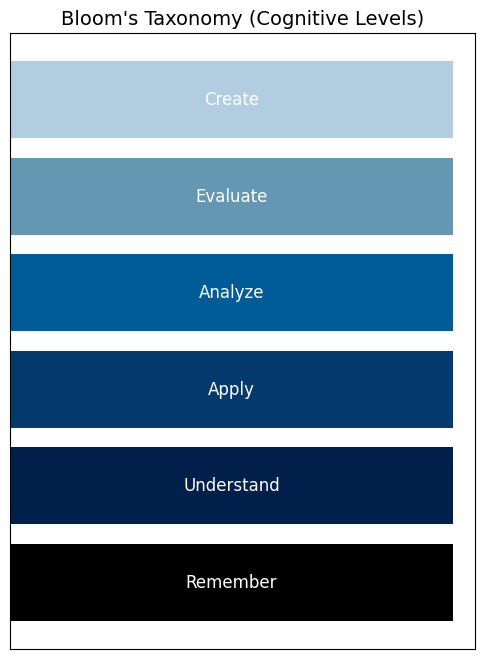


------------------------------------------------------------
                         MAIN MENU
------------------------------------------------------------
1. Upload and Process Document
2. Take a Quiz (Short Answer)
3. Take Adaptive Quiz
4. Generate Questions on a Topic
5. Generate Multiple Choice Questions
6. Study Flashcards
7. Generate Flashcards
8. Visualize Bloom's Taxonomy
9. System Information
0. Exit

Enter your choice (0-9): 9

🧠 System Components:
- DuckDB storage (in-memory)
- SentenceTransformer for embeddings
- LLaMA for question/answer generation
- Chunked document ingestion with overlap
- RAG-style semantic retrieval
- Short answer, MCQ, and adaptive quizzes
- Flashcard generator and visualizer
- Bloom’s taxonomy cognitive levels


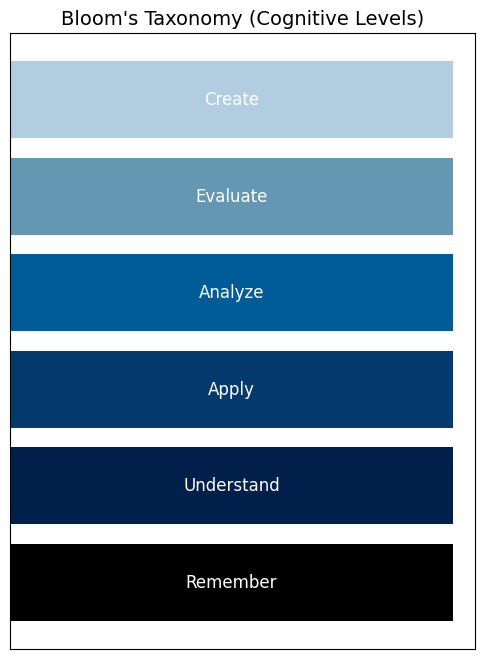


------------------------------------------------------------
                         MAIN MENU
------------------------------------------------------------
1. Upload and Process Document
2. Take a Quiz (Short Answer)
3. Take Adaptive Quiz
4. Generate Questions on a Topic
5. Generate Multiple Choice Questions
6. Study Flashcards
7. Generate Flashcards
8. Visualize Bloom's Taxonomy
9. System Information
0. Exit

Enter your choice (0-9): 9

🧠 System Components:
- DuckDB storage (in-memory)
- SentenceTransformer for embeddings
- LLaMA for question/answer generation
- Chunked document ingestion with overlap
- RAG-style semantic retrieval
- Short answer, MCQ, and adaptive quizzes
- Flashcard generator and visualizer
- Bloom’s taxonomy cognitive levels


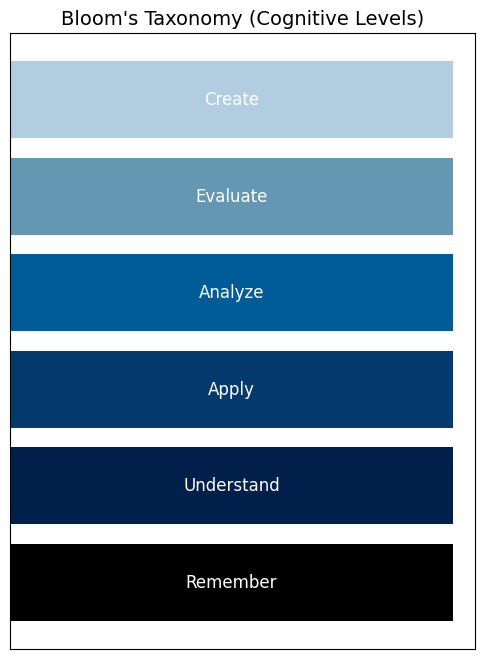


------------------------------------------------------------
                         MAIN MENU
------------------------------------------------------------
1. Upload and Process Document
2. Take a Quiz (Short Answer)
3. Take Adaptive Quiz
4. Generate Questions on a Topic
5. Generate Multiple Choice Questions
6. Study Flashcards
7. Generate Flashcards
8. Visualize Bloom's Taxonomy
9. System Information
0. Exit

Enter your choice (0-9): 0
👋 Exiting Enhanced Learning Assistant. Goodbye!


In [34]:
assistant = EnhancedLearningAssistant()
initialized = assistant.initialize()
if initialized:
    assistant.main_menu()


#V1 - LLAMA + Fiass

In [1]:
# Installing required dependencies
!pip install -q \
    faiss-cpu \
    sentence-transformers \
    llama-cpp-python==0.2.24 \
    tqdm \
    matplotlib \
    fpdf \
    PyMuPDF \
    PyPDF2

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.8/8.8 MB 9.9 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.7/30.7 MB 75.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.0/20.0 MB 115.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 232.6/232.6 kB 21.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.5/45.5 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 88.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 28.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 53.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.0 MB/

In [2]:
# Import necessary libraries
import os
import re
import uuid
import faiss
import numpy as np
import pickle
from tqdm import tqdm
from io import BytesIO
from IPython.display import display, HTML
from fpdf import FPDF
from PyPDF2 import PdfReader
from google.colab import files
import matplotlib.pyplot as plt

In [3]:
def download_llama_model():
    os.makedirs("/content/models", exist_ok=True)
    model_path = "/content/models/llama-2-7b-chat.Q4_K_M.gguf"

    if not os.path.exists(model_path):
        print("⬇️ Downloading LLaMA 2 GGUF model...")
        !wget -q https://huggingface.co/TheBloke/Llama-2-7B-Chat-GGUF/resolve/main/llama-2-7b-chat.Q4_K_M.gguf -O {model_path}
        print("✅ Download complete.")
    else:
        print("✅ LLaMA model already exists.")

    return model_path


llama_model_path = download_llama_model()

⬇️ Downloading LLaMA 2 GGUF model...
✅ Download complete.


In [4]:
from llama_cpp import Llama

def load_llama_cpu_model():
    model_path = "/content/models/llama-2-7b-chat.Q4_K_M.gguf"
    print("🧠 Loading LLaMA model on CPU...")
    return Llama(
        model_path=model_path,
        n_ctx=2048,
        n_threads=4,
        n_gpu_layers=0  # CPU only
    )

llm = load_llama_cpu_model()



🧠 Loading LLaMA model on CPU...


AVX = 1 | AVX2 = 1 | AVX512 = 1 | AVX512_VBMI = 0 | AVX512_VNNI = 0 | FMA = 1 | NEON = 0 | ARM_FMA = 0 | F16C = 1 | FP16_VA = 0 | WASM_SIMD = 0 | BLAS = 0 | SSE3 = 1 | SSSE3 = 1 | VSX = 0 | 


In [5]:
class FAISSStorage:
    """Handles all DB operations using FAISS and in-memory storage"""

    def __init__(self):
        # Initialize FAISS index for embeddings
        self.embedding_dimension = 384  # MiniLM-L6-v2 dimension
        self.index = faiss.IndexFlatL2(self.embedding_dimension)

        # In-memory storage for documents and embeddings
        self.learning_materials = {}
        self.embeddings = []
        self.embedding_ids = []

        # Check if FAISS index is empty
        self.is_index_empty = True

        print("✅ FAISS vector storage initialized.")

    def add_learning_material(self, title, content, topic, difficulty):
        material_id = str(uuid.uuid4())
        try:
            self.learning_materials[material_id] = {
                "id": material_id,
                "title": title,
                "content": content,
                "topic": topic,
                "difficulty": difficulty
            }
            return material_id
        except Exception as e:
            print(f"❌ Error adding material: {e}")
            return None

    def get_learning_material(self, material_id):
        try:
            material = self.learning_materials.get(material_id)
            if not material:
                return None
            return (
                material["id"],
                material["title"],
                material["content"],
                material["topic"],
                material["difficulty"]
            )
        except Exception as e:
            print(f"❌ Error fetching material: {e}")
            return None

    def add_embedding(self, material_id, embedding, chunk_text, chunk_start, chunk_end):
        chunk_id = str(uuid.uuid4())
        try:
            # Convert embedding to numpy array and ensure it's float32
            embedding_np = np.array(embedding, dtype=np.float32).reshape(1, -1)

            # Add to FAISS index
            self.index.add(embedding_np)
            self.is_index_empty = False

            # Store metadata
            self.embedding_ids.append({
                "id": chunk_id,
                "material_id": material_id,
                "chunk_start": chunk_start,
                "chunk_end": chunk_end,
                "chunk_text": chunk_text,
                "embedding": embedding  # Store the original embedding too
            })
            print(f"🔍 Added embedding for chunk {len(self.embedding_ids)}")
        except Exception as e:
            print(f"❌ Error adding embedding: {e}")

    def search_by_topic(self, topic):
        results = []
        for material_id, material in self.learning_materials.items():
            if material["topic"].lower() == topic.lower():
                results.append((
                    material["id"],
                    material["title"],
                    material["content"]
                ))
        return results

    def search_similar_materials(self, embedding, top_k=3):
        # If no embeddings exist yet, return empty list
        if self.is_index_empty or len(self.embedding_ids) == 0:
            print("[INFO] No embeddings in storage yet for similarity search.")
            return []

        try:
            # Convert embedding to numpy array
            query_vector = np.array(embedding, dtype=np.float32).reshape(1, -1)

            # Adjust top_k to not exceed available embeddings
            actual_top_k = min(top_k, len(self.embedding_ids))

            if actual_top_k == 0:
                return []

            # Search in FAISS
            D, I = self.index.search(query_vector, actual_top_k)

            result = []
            for i, idx in enumerate(I[0]):
                if idx >= 0 and idx < len(self.embedding_ids):  # Valid index check
                    material_id = self.embedding_ids[idx]["material_id"]
                    chunk_text = self.embedding_ids[idx]["chunk_text"]
                    stored_embedding = self.embedding_ids[idx]["embedding"]
                    similarity = 1.0 - float(D[0][i])  # Convert distance to similarity score (0-1)

                    # Only include results with reasonable similarity
                    if similarity > 0.1:  # Adjust threshold as needed
                        result.append((material_id, chunk_text, stored_embedding, similarity))
                        print(f"[DEBUG] Match: similarity={similarity:.4f}")

            # Sort by similarity (highest first)
            result.sort(key=lambda x: x[3], reverse=True)

            print(f"[INFO] Found {len(result)} similar materials")
            return result

        except Exception as e:
            print(f"[ERROR] Failed to search similar materials: {e}")
            import traceback
            traceback.print_exc()
            return []

In [7]:
class DocumentProcessor:
    """Class to process uploaded documents and extract text content"""

    def __init__(self, db, embedding_model):
        self.db = db
        self.embedding_model = embedding_model
        self.chunk_size = 1000
        self.chunk_overlap = 200

    def process_upload(self):
        """Process uploaded files and prompt for topic with domain detection"""
        try:
            print("📄 Please upload a document (PDF, TXT, or MD file):")
            uploaded = files.upload()

            if not uploaded:
                print("⚠️ No files were uploaded.")
                return []

            processed_materials = []

            for filename, content in uploaded.items():
                print(f"\n📥 Processing file: {filename}")
                file_ext = filename.split('.')[-1].lower()

                if file_ext == 'pdf':
                    text_content = self._extract_text_from_pdf(content)
                elif file_ext in ['txt', 'md']:
                    text_content = content.decode('utf-8')
                else:
                    print(f"❌ Unsupported file type: {file_ext}")
                    continue

                if not text_content.strip():
                    print(f"❌ Could not extract text from {filename}")
                    continue

                # Topic detection
                detected_topics = self._detect_topics(text_content)
                suggested_topic = self._guess_topic_from_filename(filename)
                suggestions = ", ".join(detected_topics[:3]) if detected_topics else suggested_topic

                print(f"🧠 Detected topic suggestions: {suggestions}")
                topic = input(f"Enter topic for this document (default: {suggested_topic}): ").strip() or suggested_topic

                # Difficulty input
                while True:
                    try:
                        level = input("Enter difficulty level (1-5, default: 3): ").strip()
                        difficulty = int(level) if level else 3
                        if 1 <= difficulty <= 5:
                            break
                        else:
                            print("Please enter a number between 1 and 5.")
                    except:
                        print("Invalid input. Using default difficulty: 3.")
                        difficulty = 3
                        break

                material_id = self.db.add_learning_material(filename, text_content, topic, difficulty)
                if not material_id:
                    print(f"❌ Failed to store {filename}")
                    continue

                chunks = self._chunk_text(text_content)
                print(f"🔍 Generating embeddings for {len(chunks)} chunks...")

                for chunk_text, start, end in tqdm(chunks):
                    try:
                        embedding = self.embedding_model.encode(chunk_text).tolist()
                        self.db.add_embedding(material_id, embedding, chunk_text, start, end)
                    except Exception as e:
                        print(f"❌ Error encoding chunk: {e}")
                        continue

                processed_materials.append(self.db.get_learning_material(material_id))
                print(f"✅ Successfully processed {filename}")

            return processed_materials

        except Exception as e:
            print(f"❌ Error processing upload: {e}")
            import traceback
            traceback.print_exc()
            return []

    def _extract_text_from_pdf(self, pdf_content):
        try:
            reader = PdfReader(BytesIO(pdf_content))
            text = "\n\n".join([page.extract_text() or "" for page in reader.pages])
            if not text.strip():
                print("⚠️ PDF extraction returned empty text. Trying alternate method...")
                # If primary method fails, attempt alternative extraction
                import fitz  # PyMuPDF
                doc = fitz.open(stream=pdf_content, filetype="pdf")
                text = ""
                for page in doc:
                    text += page.get_text() + "\n\n"
                doc.close()
            return text
        except Exception as e:
            print(f"❌ Error extracting text from PDF: {e}")
            return ""

    def _chunk_text(self, text):
        chunks = []

        # Handle case where text is too short
        if len(text) <= self.chunk_size:
            chunks.append((text, 0, len(text)))
            return chunks

        # Split into paragraphs
        paragraphs = [p for p in text.split('\n\n') if p.strip()]

        # Process paragraphs into chunks
        current_chunk = ""
        current_start = 0

        for para in paragraphs:
            para = para.strip()
            if not para:
                continue

            # If adding this paragraph would exceed chunk size
            if len(current_chunk) + len(para) > self.chunk_size:
                if current_chunk:  # Save the current chunk
                    chunks.append((current_chunk, current_start, current_start + len(current_chunk)))

                # Handle case where a single paragraph is larger than chunk_size
                if len(para) > self.chunk_size:
                    # Split the paragraph into smaller chunks
                    sentences = re.split(r'(?<=[.!?])\s+', para)
                    sub_chunk = ""
                    sub_start = text.find(para)

                    for sentence in sentences:
                        if len(sub_chunk) + len(sentence) > self.chunk_size:
                            if sub_chunk:
                                chunks.append((sub_chunk, sub_start, sub_start + len(sub_chunk)))
                            sub_chunk = sentence
                            sub_start = text.find(sentence, sub_start)
                        else:
                            if not sub_chunk:
                                sub_start = text.find(sentence, sub_start)
                            sub_chunk += " " + sentence if sub_chunk else sentence

                    if sub_chunk:
                        chunks.append((sub_chunk, sub_start, sub_start + len(sub_chunk)))

                    current_chunk = ""
                    current_start = 0
                else:
                    # Start a new chunk with this paragraph
                    current_chunk = para
                    current_start = text.find(para)
            else:
                # Add to current chunk
                if current_chunk:
                    current_chunk += "\n\n" + para
                else:
                    current_chunk = para
                    current_start = text.find(para)

        # Don't forget the last chunk
        if current_chunk:
            chunks.append((current_chunk, current_start, current_start + len(current_chunk)))

        # Add overlapping chunks if specified
        if self.chunk_overlap and len(chunks) > 1:
            overlaps = []
            for i in range(len(chunks) - 1):
                c1, s1, e1 = chunks[i]
                c2, s2, e2 = chunks[i + 1]

                # Calculate reasonable overlap
                overlap_len = min(self.chunk_overlap, len(c1), len(c2))
                if overlap_len > 50:  # Only create overlap if it's substantial
                    # Create text that bridges the two chunks
                    text_ov = c1[-overlap_len:] + "\n\n" + c2[:overlap_len]
                    overlaps.append((text_ov, e1 - overlap_len, s2 + overlap_len))

            chunks.extend(overlaps)
            chunks.sort(key=lambda x: x[1])  # Sort by start position

        print(f"📋 Created {len(chunks)} chunks from text ({len(text)} characters)")
        return chunks

    def _guess_topic_from_filename(self, filename):
        name = '.'.join(filename.split('.')[:-1])
        name = name.replace('_', ' ').replace('-', ' ')
        # Remove file numbers and extensions
        name = re.sub(r'\s*\(\d+\)', '', name)
        return ' '.join(name.split()[:3])

    def _detect_topics(self, text):
        domain_keywords = {
            "Climate": ["climate", "global warming", "carbon", "temperature", "greenhouse", "environment"],
            "Machine Learning": ["machine learning", "algorithm", "neural network", "AI", "training", "model", "classification", "regression"],
            "Python Programming": ["python", "list", "function", "pandas", "numpy", "script", "class", "module"],
            "Astronomy": ["planet", "orbit", "sun", "solar", "galaxy", "universe", "star", "celestial"],
            "Data Science": ["data", "analysis", "visualization", "statistics", "dataset", "correlation", "prediction"],
            "Mathematics": ["equation", "theorem", "proof", "algebra", "calculus", "geometry", "matrix"],
            "Physics": ["force", "energy", "motion", "quantum", "relativity", "particle", "field"],
            "Computer Science": ["algorithm", "data structure", "complexity", "recursion", "sorting", "search", "computation"]
        }

        scores = {domain: 0 for domain in domain_keywords}

        # Convert text to lowercase for case-insensitive matching
        text_lower = text.lower()

        for domain, keywords in domain_keywords.items():
            for kw in keywords:
                # Count occurrences and weight by keyword length (longer keywords are more specific)
                count = len(re.findall(r'\b' + re.escape(kw) + r'\b', text_lower))
                if count > 0:
                    # Weigh longer keywords more heavily as they're more specific
                    scores[domain] += count * (1 + 0.1 * len(kw))

        # Sort domains by score and filter those with a score > 0
        ranked_topics = [topic for topic, score in sorted(scores.items(), key=lambda x: -x[1]) if score > 0]

        return ranked_topics

In [8]:
class QuestionGenerator:
    """Handles generating questions using LLaMA and context from FAISS"""

    def __init__(self, db, llm, embedding_model):
        self.db = db
        self.llm = llm
        self.embedding_model = embedding_model

    def generate_questions(self, topic, difficulty=3, num_questions=5):
        print(f"\n[START] Generating Questions for topic: '{topic}'")
        embedding = self.embedding_model.encode(topic).tolist()

        print("[INFO] Generating embedding for query:", topic)
        print("[INFO] Query embedding generated successfully")

        print("[INFO] Searching for similar materials in DB")
        matches = self.db.search_similar_materials(embedding)

        if not matches:
            print("[WARN] No relevant materials found for topic:", topic)
            print("[INFO] Using default knowledge about the topic...")
            # Create synthetic context
            context = f"""
            {topic} is an important subject to learn about.
            {topic} contains key principles and concepts.
            Questions about {topic} should test understanding at level {difficulty} (1-5 scale).
            """
        else:
            context = "\n\n".join([m[1] for m in matches[:2]])  # Limit to top 2 chunks for faster prompt

        # Enhanced prompt with clearer instructions and system message
        prompt = f"""You are an expert educator creating quiz questions.

Generate exactly {num_questions} numbered questions for the topic "{topic}" with difficulty level {difficulty} (on a scale of 1-5, where 5 is most difficult).

Use this context to form factual, answerable questions:
{context}

Your response must ONLY contain the numbered questions like this:
1. [First question about {topic}]?
2. [Second question about {topic}]?
3. [And so on...]

Make sure each question ends with a question mark and focuses on a different aspect of {topic}.
"""

        print("[INFO] Sending prompt to LLM...")
        output = ""
        try:
            # First try with streaming
            print("Generating questions...", end="", flush=True)
            for chunk in self.llm(prompt, max_tokens=512, stream=True, temperature=0.2):
                token = chunk["choices"][0]["text"]
                output += token
                # Print progress
                if len(output) % 50 == 0:
                    print(".", end="", flush=True)
            print(" Done!")
        except Exception as e:
            print(f"\n[ERROR] Failed during streaming: {e}")
            # Fallback to non-streaming generation
            try:
                output = self.llm(prompt, max_tokens=512, temperature=0.1)
                output = output["choices"][0]["text"] if isinstance(output, dict) else output
            except Exception as e2:
                print(f"\n[ERROR] Failed during fallback generation: {e2}")
                # Create synthetic questions as last resort
                output = self._generate_synthetic_questions(topic, num_questions)

        print("\n[INFO] LLM response received.")

        # Improved parsing to handle different formats
        questions = []

        # Try to extract numbered questions first (format: "1. Question text")
        numbered_pattern = re.compile(r'\d+\.\s*(.*?)\s*(?=\d+\.|$)', re.DOTALL)
        matches = numbered_pattern.findall(output)

        if matches:
            questions = [q.strip() for q in matches if q.strip()]
        else:
            # Alternative parsing for line-by-line questions
            lines = [line.strip() for line in output.split("\n") if line.strip()]
            questions = [line for line in lines if not line.startswith("[") and not line.endswith(":")]

        # Filter out any non-question lines and limit to requested number
        questions = [q for q in questions if "?" in q or len(q) > 15][:num_questions]

        if len(questions) == 0:
            print("[WARN] Could not parse any questions from LLM response. Using fallback questions.")
            questions = self._generate_synthetic_questions(topic, num_questions)

        print(f"[COMPLETE] Generated {len(questions)} questions.\n")
        for i, q in enumerate(questions, 1):
            print(f"Q{i}. {q}")
        return questions

    def _generate_synthetic_questions(self, topic, num_questions):
        """Create basic questions when LLM fails"""
        topic_lower = topic.lower()

        basic_templates = [
            f"What is the definition of {topic}?",
            f"What are the main components of {topic}?",
            f"How does {topic} impact everyday life?",
            f"What are the historical origins of {topic}?",
            f"Who are the key figures associated with {topic}?",
            f"What are common misconceptions about {topic}?",
            f"How has {topic} evolved over time?",
            f"What is the relationship between {topic} and related fields?",
            f"What are the future trends in {topic}?",
            f"How is {topic} applied in professional settings?"
        ]

        # Return requested number of questions
        return basic_templates[:num_questions]

    def generate_multiple_choice_questions(self, topic, difficulty=3, num_questions=5):
        """Generate multiple choice questions"""
        print(f"\n[START] Generating MCQs for '{topic}' (level {difficulty})")

        # Prompt user for number of MCQs if using from menu
        try:
            num_input = input("How many multiple-choice questions to generate? (e.g., 3): ").strip()
            if num_input:
                num_questions = int(num_input)
        except:
            print("⚠️ Invalid input. Using default:", num_questions)

        embedding = self.embedding_model.encode(topic).tolist()
        matches = self.db.search_similar_materials(embedding)

        if not matches:
            print("[WARN] No relevant materials found for topic:", topic)
            print("[INFO] Using default knowledge about the topic...")
            # Create synthetic context
            context = f"""
            {topic} is an important subject with various key concepts.
            Multiple choice questions about {topic} should test understanding at level {difficulty} (1-5 scale).
            Each question should have one correct answer and three plausible but incorrect options.
            """
        else:
            context = "\n\n".join([m[1] for m in matches[:2]])

        # Clearer prompt with example
        prompt = f"""You are an expert educator creating multiple choice questions.

Create exactly {num_questions} multiple choice questions (MCQs) on the topic "{topic}" with difficulty level {difficulty} (on a scale of 1-5, where 5 is most difficult).

Each question MUST have 1 correct answer and 3 incorrect choices.

Context information:
{context}

Format EXACTLY as follows (including the Q1, Q2 numbering):

Q1: [Question text]
A. [Option text]
B. [Option text]
C. [Option text]
D. [Option text]
Answer: [Correct letter (A, B, C, or D)]

Q2: [Question text]
A. [Option text]
B. [Option text]
C. [Option text]
D. [Option text]
Answer: [Correct letter]

Make sure every question follows this EXACT format.
"""

        print("[INFO] Sending prompt to LLM...")
        try:
            print("Generating MCQs...", end="", flush=True)
            response = ""
            for chunk in self.llm(prompt, max_tokens=1024, stream=True, temperature=0.2):
                token = chunk["choices"][0]["text"]
                response += token
                # Print progress
                if len(response) % 50 == 0:
                    print(".", end="", flush=True)
            print(" Done!")
        except Exception as e:
            print(f"\n[ERROR] Error during streaming: {e}")
            # Fallback to non-streaming
            try:
                response = self.llm(prompt, max_tokens=1024, temperature=0.1)
                response = response["choices"][0]["text"] if isinstance(response, dict) else response
            except Exception as e2:
                print(f"\n[ERROR] Fallback generation also failed: {e2}")
                response = self._generate_synthetic_mcqs(topic, num_questions)

        # Check if response has proper format
        if "Q1:" not in response or "Answer:" not in response:
            print("[WARN] LLM response does not contain proper MCQ format. Using fallback MCQs.")
            response = self._generate_synthetic_mcqs(topic, num_questions)

        print("[INFO] LLM response received.")
        print(f"[COMPLETE] MCQs generated.\n")
        print(response)
        return response

    def _generate_synthetic_mcqs(self, topic, num_questions):
        """Create basic MCQs when LLM fails"""
        mcq_text = f"Multiple Choice Questions about {topic}:\n\n"

        templates = [
            {
                "question": f"What is the primary focus of {topic}?",
                "options": [
                    "Understanding key principles and concepts",
                    "Historical development only",
                    "Application without theory",
                    "Theoretical models only"
                ],
                "answer": "A"
            },
            {
                "question": f"Which of the following best describes {topic}?",
                "options": [
                    "A field of study with practical applications",
                    "An outdated concept",
                    "A purely theoretical construct",
                    "A recent invention with no history"
                ],
                "answer": "A"
            },
            {
                "question": f"What is a common challenge when studying {topic}?",
                "options": [
                    "Integrating theory with practice",
                    "Finding relevant materials",
                    "Understanding basic concepts",
                    "Connecting with experts"
                ],
                "answer": "A"
            }
        ]

        for i in range(min(num_questions, len(templates))):
            template = templates[i]
            mcq_text += f"Q{i+1}: {template['question']}\n"
            mcq_text += f"A. {template['options'][0]}\n"
            mcq_text += f"B. {template['options'][1]}\n"
            mcq_text += f"C. {template['options'][2]}\n"
            mcq_text += f"D. {template['options'][3]}\n"
            mcq_text += f"Answer: {template['answer']}\n\n"

        return mcq_text

In [9]:
class FlashcardGenerator:
    """Generates flashcards from learning content"""

    def __init__(self, db, llm, embedding_model):
        self.db = db
        self.llm = llm
        self.embedding_model = embedding_model

    def generate_flashcards(self, topic, num_cards=5, conciseness="high"):
        print(f"\n[START] Generating Flashcards for topic: '{topic}'")
        embedding = self.embedding_model.encode(topic).tolist()
        matches = self.db.search_similar_materials(embedding)

        if not matches:
            print("[WARN] No relevant materials found. Using fallback text.")
            # Create synthetic context about the topic
            context = f"""
            {topic} is an important subject in education.
            {topic} has several key concepts that students should understand.
            Create flashcards with clear concepts and definitions related to {topic}.
            """
        else:
            print(f"[INFO] Found {len(matches)} matching materials for context")
            context = "\n\n".join([m[1] for m in matches])

        # Direct prompt with explicit example to help LLaMA generate correct format
        prompt = f"""You are creating {num_cards} flashcards on {topic}.
Each flashcard MUST follow EXACTLY this format:

Flashcard 1:
Concept: [specific concept about {topic}]
Definition: [clear explanation of the concept]

Flashcard 2:
Concept: [specific concept about {topic}]
Definition: [clear explanation of the concept]

Here's an example of how your output should look:

Flashcard 1:
Concept: Climate Change
Definition: The long-term alteration of temperature and typical weather patterns in a place.

Flashcard 2:
Concept: Greenhouse Effect
Definition: A natural process that warms Earth's surface due to the presence of atmospheric gases that trap heat.

Now create {num_cards} flashcards for {topic} following this exact format. Use this context:
{context}

REMEMBER: Your response must contain ONLY the flashcards in the exact format shown, nothing else.
"""

        print("[INFO] Sending prompt to LLM...")

        # Use temperature parameter to encourage more deterministic output
        try:
            # First try with streaming for user feedback
            response = ""
            print("Generating flashcards...", end="", flush=True)
            for chunk in self.llm(prompt, max_tokens=1024, stream=True, temperature=0.2):
                token = chunk["choices"][0]["text"]
                response += token
                # Print simple progress indicator
                if len(response) % 50 == 0:
                    print(".", end="", flush=True)
            print(" Done!")
        except Exception as e:
            print(f"\n[ERROR] Streaming generation failed: {e}")
            # Fallback to non-streaming with different parameters
            try:
                response = self.llm(prompt, max_tokens=1024, temperature=0.1)
                if isinstance(response, dict) and "choices" in response:
                    response = response["choices"][0]["text"]
            except Exception as e2:
                print(f"[ERROR] Fallback generation also failed: {e2}")
                # Create synthetic flashcards if all else fails
                response = self._generate_synthetic_flashcards(topic, num_cards)

        # If the response doesn't contain flashcard format, try to fix it
        if "Flashcard" not in response or "Concept:" not in response:
            print("[WARN] LLM response does not contain proper flashcard format. Creating synthetic flashcards.")
            response = self._generate_synthetic_flashcards(topic, num_cards)
            print("[INFO] Flashcards generated.\n")
        print(response)
        return response

    def _generate_synthetic_flashcards(self, topic, num_cards):
        """Create synthetic flashcards when LLM fails to generate proper format"""

        # Dictionary of common topics and their flashcard content
        topic_templates = {
            "climate": [
                ("Climate Change", "The long-term alteration of temperature and typical weather patterns globally or regionally."),
                ("Greenhouse Effect", "A natural process that warms Earth's surface due to atmospheric gases trapping heat."),
                ("Global Warming", "The observed increase in Earth's average temperature due to human activities."),
                ("Carbon Footprint", "The total amount of greenhouse gases emitted by human activities."),
                ("Climate Mitigation", "Actions to reduce or prevent greenhouse gas emissions.")
            ],
            "python": [
                ("Variable", "A named storage location that can hold data values in Python."),
                ("Function", "A reusable block of code that performs a specific task in Python."),
                ("List", "An ordered, mutable collection of elements in Python."),
                ("Dictionary", "A collection of key-value pairs in Python."),
                ("Class", "A blueprint for creating objects that define attributes and methods.")
            ],
            "machine learning": [
                ("Supervised Learning", "A type of ML where algorithms learn from labeled training data."),
                ("Neural Network", "A series of algorithms modeled after the human brain."),
                ("Overfitting", "When a model learns the training data too well, including noise and outliers."),
                ("Feature Engineering", "The process of selecting and transforming variables for model training."),
                ("Gradient Descent", "An optimization algorithm for minimizing the error in prediction models.")
            ]
        }

        # Find the most relevant template based on topic
        selected_cards = None
        topic_lower = topic.lower()

        for key, cards in topic_templates.items():
            if key in topic_lower:
                selected_cards = cards
                break

        # Use generic templates if no specific match found
        if not selected_cards:
            selected_cards = [
                (f"{topic} Basics", f"The fundamental principles and concepts of {topic}."),
                (f"{topic} History", f"The historical development and evolution of {topic}."),
                (f"{topic} Applications", f"How {topic} is applied in real-world contexts."),
                (f"{topic} Importance", f"Why {topic} matters and its significance in its field."),
                (f"{topic} Future Trends", f"Emerging developments and future directions in {topic}.")
            ]

        # Format cards according to the expected format
        result = ""
        for i in range(min(num_cards, len(selected_cards))):
            concept, definition = selected_cards[i]
            result += f"Flashcard {i+1}:\nConcept: {concept}\nDefinition: {definition}\n\n"

        return result

In [10]:
class FlashcardStudySystem:
    """Interactive flashcard study session"""

    def __init__(self, db, generator):
        self.db = db
        self.generator = generator

    def start_study_session(self, topic, num_cards=5):
        raw = self.generator.generate_flashcards(topic, num_cards)
        cards = self._parse_flashcards(raw)

        print(f"\n🧠 Studying {len(cards)} flashcards...\n")
        if len(cards) == 0:
            # If no cards were parsed, create some from the raw text directly
            print("⚠️ Could not parse flashcards from model output. Using raw output as flashcards.")
            # Split text into chunks and create simple flashcards
            chunks = [chunk.strip() for chunk in raw.split("\n\n") if chunk.strip()]
            if chunks:
                # Create at least one flashcard from the raw text
                cards = [{"concept": f"Topic: {topic}", "definition": chunks[0]}]
                for i, chunk in enumerate(chunks[1:], 1):
                    if i < num_cards:
                        cards.append({"concept": f"Aspect {i} of {topic}", "definition": chunk})

        for i, card in enumerate(cards, 1):
            print(f"\nCard {i}:")
            print("Concept:", card['concept'])
            input("Press Enter to show definition...")
            print("Definition:", card['definition'])
        print("\n✅ Study session complete.")
        return len(cards)

    def _parse_flashcards(self, text):
        cards = []

        # First try the standard format
        standard_pattern = re.compile(r'Flashcard \d+:\s*Concept:(.*?)\s*Definition:(.*?)(?=Flashcard \d+:|$)', re.DOTALL)
        matches = standard_pattern.findall(text)

        if matches:
            for concept, definition in matches:
                cards.append({
                    "concept": concept.strip(),
                    "definition": definition.strip()
                })
            return cards

        # Try an alternative format if the first one failed
        alt_pattern = re.compile(r'Concept:(.*?)\s*Definition:(.*?)(?=Concept:|$)', re.DOTALL)
        matches = alt_pattern.findall(text)

        if matches:
            for concept, definition in matches:
                cards.append({
                    "concept": concept.strip(),
                    "definition": definition.strip()
                })

        return cards

In [11]:
class QuizSystem:
    """Conducts quizzes using QuestionGenerator"""

    def __init__(self, db, question_generator):
        self.db = db
        self.qg = question_generator

    def take_quiz(self, topic=None, difficulty=3, num_questions=5):
        print("\n📝 Starting Quiz...")

        # Prompt for topic if not provided
        if not topic or topic.strip() == "":
            topic = input("Enter topic for this quiz: ").strip()

        # Prompt for difficulty if needed
        try:
            diff_input = input(f"Enter difficulty level (1-5, default: {difficulty}): ").strip()
            if diff_input:
                difficulty = int(diff_input)
                if difficulty < 1 or difficulty > 5:
                    print(f"⚠️ Invalid difficulty. Using default: {difficulty}")
                    difficulty = 3
        except:
            print(f"⚠️ Invalid input. Using default difficulty: {difficulty}")

        # Generate questions
        questions = self.qg.generate_questions(topic, difficulty, num_questions)

        if not questions or len(questions) == 0:
            print("⚠️ No questions could be generated. Try a different topic.")
            return 0

        score = 0
        answers = []

        for i, q in enumerate(questions, 1):
            print(f"\nQ{i}: {q}")
            user_answer = input("Your answer (or type 'skip' to see answer): ").strip()

            if user_answer.lower() == "skip":
                # Ask LLaMA for an answer
                prompt = f"""You are a helpful educational assistant.

Context: The topic is {topic}.
Question: {q}

Provide a short, factual answer to this question in 1-3 sentences:"""

                print("[INFO] Asking LLM for the answer...")

                try:
                    # Use streaming to get answer incrementally
                    answer = ""
                    for chunk in self.qg.llm(prompt, max_tokens=150, stream=True):
                        token = chunk["choices"][0]["text"]
                        answer += token
                        print(token, end="", flush=True)
                    print("\n")
                except Exception as e:
                    print(f"\n[ERROR] LLM answer generation error: {e}")
                    # Fallback to non-streaming
                    response = self.qg.llm(prompt)
                    answer = response["choices"][0]["text"] if isinstance(response, dict) else response

                print(f"✔️ Skipped. Model Answer:\n{answer.strip()}\n")
                answers.append(("skip", answer.strip()))
            else:
                print("✔️ Answer submitted.")

                # Evaluate the answer with LLaMA
                eval_prompt = f"""You are an educational evaluator.

Topic: {topic}
Question: {q}
Student's Answer: {user_answer}

Is this answer correct? Respond with "CORRECT" or "INCORRECT" followed by a brief explanation:"""

                try:
                    print("[INFO] Evaluating answer...")
                    eval_result = ""
                    for chunk in self.qg.llm(eval_prompt, max_tokens=100, stream=True):
                        token = chunk["choices"][0]["text"]
                        eval_result += token

                    # Check if the answer was marked correct
                    if "CORRECT" in eval_result.upper():
                        score += 1
                        print("✅ Your answer was marked as CORRECT!")
                    else:
                        print("❌ Your answer was marked as INCORRECT.")

                    # Get explanation without the CORRECT/INCORRECT marker
                    explanation = eval_result.replace("CORRECT", "").replace("INCORRECT", "").strip()
                    if explanation:
                        print(f"Feedback: {explanation}")
                except Exception as e:
                    print(f"[ERROR] Could not evaluate answer: {e}")

                answers.append((user_answer, eval_result))

        # Show summary
        print(f"\n✅ Quiz complete! Score: {score}/{len(questions)}")

        # Ask if user wants to review answers
        if input("Review your answers? (y/n): ").lower().startswith("y"):
            print("\n📋 Answer Review:")
            for i, (q, (user_ans, feedback)) in enumerate(zip(questions, answers), 1):
                print(f"\nQ{i}: {q}")
                print(f"Your answer: {user_ans if user_ans != 'skip' else '[SKIPPED]'}")
                print(f"Feedback: {feedback}")

        return len(questions)

    def take_adaptive_quiz(self, topic=None, initial_difficulty=2, num_questions=5):
        print("\n📈 Starting Adaptive Quiz...")

        # Prompt for topic if not provided
        if not topic or topic.strip() == "":
            topic = input("Enter topic for this adaptive quiz: ").strip()

        # Allow customizing number of questions
        try:
            num_input = input(f"Number of questions (default: {num_questions}): ").strip()
            if num_input:
                num_questions = int(num_input)
        except:
            print(f"⚠️ Invalid input. Using default: {num_questions} questions")

        difficulty = initial_difficulty
        questions_asked = 0
        correct_answers = 0

        print(f"\n🎯 Starting at difficulty level {difficulty}/5")

        for i in range(num_questions):
            questions = self.qg.generate_questions(topic, difficulty, num_questions=1)

            if not questions or len(questions) == 0:
                print("⚠️ Could not generate question. Adjusting difficulty...")
                difficulty = max(1, difficulty - 1)
                continue

            question = questions[0]
            questions_asked += 1

            print(f"\nQ{i+1} (Difficulty {difficulty}/5): {question}")

            user_answer = input("Your answer (or 'skip'): ").strip()

            if user_answer.lower() == "skip":
                print("⏩ Question skipped. Decreasing difficulty...")
                difficulty = max(1, difficulty - 1)

                # Show the answer anyway
                answer_prompt = f"Context: The topic is {topic}.\nQuestion: {question}\nProvide a short, factual answer:"
                print("[INFO] Correct answer:")

                try:
                    answer = ""
                    for chunk in self.qg.llm(answer_prompt, max_tokens=100, stream=True):
                        token = chunk["choices"][0]["text"]
                        answer += token
                        print(token, end="", flush=True)
                    print("\n")
                except:
                    print("(Could not generate answer)")
            else:
                # Evaluate if the answer is correct
                eval_prompt = f"""You are an educational evaluator.

Topic: {topic}
Question: {question}
Student's Answer: {user_answer}

Is this answer correct? Reply only with "CORRECT" or "INCORRECT":"""

                try:
                    eval_result = self.qg.llm(eval_prompt)["choices"][0]["text"]
                    if "CORRECT" in eval_result.upper():
                        print("✅ Correct! Increasing difficulty.")
                        difficulty = min(5, difficulty + 1)
                        correct_answers += 1
                    else:
                        print("❌ Incorrect. Decreasing difficulty.")
                        difficulty = max(1, difficulty - 1)

                        # Show the correct answer
                        answer_prompt = f"Context: The topic is {topic}.\nQuestion: {question}\nProvide a short, factual answer:"
                        print("[INFO] Correct answer:")

                        try:
                            answer = ""
                            for chunk in self.qg.llm(answer_prompt, max_tokens=100, stream=True):
                                token = chunk["choices"][0]["text"]
                                answer += token
                                print(token, end="", flush=True)
                            print("\n")
                        except:
                            print("(Could not generate answer)")
                except Exception as e:
                    print(f"[ERROR] Could not evaluate answer: {e}")
                    # Keep same difficulty level on evaluation error

        # Final score and level
        print(f"\n✅ Adaptive Quiz complete!")
        print(f"📊 Statistics:")
        print(f"- Questions attempted: {questions_asked}/{num_questions}")
        print(f"- Correct answers: {correct_answers}")
        print(f"- Final difficulty level: {difficulty}/5")

        if difficulty >= 4:
            print("🌟 Great job! You've reached an advanced difficulty level.")
        elif difficulty >= 2:
            print("👍 Good progress. Keep practicing to increase your difficulty level.")
        else:
            print("🔄 This topic might be challenging. More practice will help you improve.")

        return questions_asked, difficulty

In [12]:
class SystemInfo:
    """Displays system information and Bloom's taxonomy"""

    @staticmethod
    def display_system_info():
        print("\n🧠 System Components:")
        print("- FAISS vector storage (in-memory)")
        print("- SentenceTransformer for embeddings")
        print("- LLaMA for question/answer generation")
        print("- Chunked document ingestion with overlap")
        print("- RAG-style semantic retrieval")
        print("- Short answer, MCQ, and adaptive quizzes")
        print("- Flashcard generator and visualizer")
        print("- Bloom's taxonomy cognitive levels")
        SystemInfo.visualize_blooms_taxonomy()

    @staticmethod
    def visualize_blooms_taxonomy():
        levels = [
            "Remember", "Understand", "Apply", "Analyze", "Evaluate", "Create"
        ]
        colors = ['#b3cde0', '#6497b1', '#005b96', '#03396c', '#011f4b', '#000000']

        try:
            fig, ax = plt.subplots(figsize=(10, 6))
            for i, level in enumerate(reversed(levels)):
                ax.barh(i, 1, color=colors[i])
                ax.text(0.5, i, level, ha='center', va='center', color='white', fontsize=14, fontweight='bold')
            ax.set_yticks([])
            ax.set_xticks([])
            ax.set_title("Bloom's Taxonomy (Cognitive Levels)", fontsize=16, fontweight='bold')
            plt.gca().invert_yaxis()
            plt.tight_layout()
            plt.show()

            # Print textual explanation
            print("\n📚 Bloom's Taxonomy Explanation:")
            print("1. Remember: Recall facts and basic concepts")
            print("2. Understand: Explain ideas or concepts")
            print("3. Apply: Use information in new situations")
            print("4. Analyze: Draw connections among ideas")
            print("5. Evaluate: Justify a stand or decision")
            print("6. Create: Produce new or original work")

        except Exception as e:
            print(f"[ERROR] Could not visualize Bloom's taxonomy: {e}")
            # Provide textual fallback
            print("\n📚 Bloom's Taxonomy Levels (in order of complexity):")
            for i, level in enumerate(levels, 1):
                print(f"{i}. {level}")

In [14]:
def load_embedding_model_from_disk():
    """Load MiniLM embedding model from disk (or download and cache it)"""
    path = "/content/models/all-MiniLM-L6-v2"
    os.makedirs(path, exist_ok=True)
    if not os.path.exists(os.path.join(path, 'config.json')):
        print("⬇️ Downloading embedding model...")
        model = SentenceTransformer("all-MiniLM-L6-v2")
        model.save(path)
    print("✅ Loaded embedding model from disk.")
    return SentenceTransformer(path)

def load_llama_cpu_model():
    """Load the LLaMA model on CPU (after downloading it on GPU earlier)"""
    model_path = "/content/models/llama-2-7b-chat.Q4_K_M.gguf"
    if not os.path.exists(model_path):
        raise FileNotFoundError("❌ LLaMA model file not found. Please download it on GPU first.")
    print("🧠 Initializing LLaMA model on CPU...")
    llm = Llama(
        model_path=model_path,
        n_ctx=2048,
        n_threads=4,
        n_gpu_layers=0  # Run only on CPU
    )
    return llm

In [15]:
class EnhancedLearningAssistant:
    """Main class that controls the learning system"""

    def __init__(self):
        print("\n==========================================================")
        print("            ENHANCED LLAMA 2 LEARNING ASSISTANT             ")
        print("==========================================================")
        print("Initializing Enhanced Learning Assistant...")

        self.db = None
        self.embedding_model = None
        self.llm = None
        self.document_processor = None
        self.question_generator = None
        self.quiz_system = None
        self.flashcard_generator = None
        self.flashcard_study_system = None
        self.system_info = None

    def initialize(self):
        try:
            print("📦 Setting up FAISS database...")
            self.db = FAISSStorage()

            print("⚙️ Initializing embedding model...")
            self.embedding_model = load_embedding_model_from_disk()

            print("🧠 Loading LLaMA model on CPU...")
            self.llm = load_llama_cpu_model()

            print("🔧 Initializing components...")
            self.document_processor = DocumentProcessor(self.db, self.embedding_model)
            self.question_generator = QuestionGenerator(self.db, self.llm, self.embedding_model)
            self.quiz_system = QuizSystem(self.db, self.question_generator)
            self.flashcard_generator = FlashcardGenerator(self.db, self.llm, self.embedding_model)
            self.flashcard_study_system = FlashcardStudySystem(self.db, self.flashcard_generator)
            self.system_info = SystemInfo

            print("✅ All components initialized successfully.")
            return True
        except Exception as e:
            print(f"❌ Error during initialization: {e}")
            import traceback
            traceback.print_exc()
            return False

    def main_menu(self):
        while True:
            print("\n" + "-" * 60)
            print("                         MAIN MENU")
            print("-" * 60)
            print("1. Upload and Process Document")
            print("2. Take a Quiz (Short Answer)")
            print("3. Take Adaptive Quiz")
            print("4. Generate Questions on a Topic")
            print("5. Generate Multiple Choice Questions")
            print("6. Study Flashcards")
            print("7. Generate Flashcards")
            print("8. Visualize Bloom's Taxonomy")
            print("9. System Information")
            print("0. Exit")

            try:
                choice = input("\nEnter your choice (0-9): ").strip()

                if choice == '1':
                    self.document_processor.process_upload()

                elif choice == '2':
                    topic = input("Enter topic: ").strip()
                    self.quiz_system.take_quiz(topic)

                elif choice == '3':
                    topic = input("Enter topic: ").strip()
                    self.quiz_system.take_adaptive_quiz(topic)

                elif choice == '4':
                    topic = input("Enter topic: ").strip()
                    num_qs = input("Number of questions (default: 5): ").strip()
                    num_questions = int(num_qs) if num_qs.isdigit() else 5
                    self.question_generator.generate_questions(topic, num_questions=num_questions)

                elif choice == '5':
                    topic = input("Enter topic: ").strip()
                    self.question_generator.generate_multiple_choice_questions(topic)

                elif choice == '6':
                    topic = input("Enter topic: ").strip()
                    num_cards = input("Number of flashcards (default: 5): ").strip()
                    num_flashcards = int(num_cards) if num_cards.isdigit() else 5
                    self.flashcard_study_system.start_study_session(topic, num_flashcards)

                elif choice == '7':
                    topic = input("Enter topic: ").strip()
                    num_cards = input("Number of flashcards (default: 5): ").strip()
                    num_flashcards = int(num_cards) if num_cards.isdigit() else 5
                    self.flashcard_generator.generate_flashcards(topic, num_flashcards)

                elif choice == '8':
                    self.system_info.visualize_blooms_taxonomy()

                elif choice == '9':
                    self.system_info.display_system_info()

                elif choice == '0':
                    print("👋 Exiting Enhanced Learning Assistant. Goodbye!")
                    break

                # Easter egg
                elif choice.lower() == 'help':
                    print("\n❓ Help Information:")
                    print("- Upload documents (PDFs, TXT) with option 1")
                    print("- Test your knowledge with quizzes (options 2-3)")
                    print("- Generate questions on any topic (options 4-5)")
                    print("- Create and study flashcards (options 6-7)")
                    print("- Learn about Bloom's taxonomy (option 8)")
                    print("- View system information (option 9)")

                else:
                    print("❌ Invalid option. Please enter a number between 0 and 9.")

            except Exception as e:
                print(f"❌ Error processing menu choice: {e}")
                print("Please try again.")

    def save_state(self, filename="learning_assistant_state.pkl"):
        """Save the current state of the learning assistant"""
        try:
            state = {
                "materials": self.db.learning_materials,
                "embedding_ids": self.db.embedding_ids,
            }

            with open(filename, 'wb') as f:
                pickle.dump(state, f)

            print(f"✅ System state saved to {filename}")
            return True
        except Exception as e:
            print(f"❌ Error saving state: {e}")
            return False

    def load_state(self, filename="learning_assistant_state.pkl"):
        """Load a previously saved state"""
        try:
            if not os.path.exists(filename):
                print(f"❌ No saved state found at {filename}")
                return False

            with open(filename, 'rb') as f:
                state = pickle.load(f)

            # Restore materials
            self.db.learning_materials = state["materials"]

            # Restore embeddings
            for emb_data in state["embedding_ids"]:
                if "embedding" in emb_data:
                    embedding_np = np.array(emb_data["embedding"], dtype=np.float32).reshape(1, -1)
                    self.db.index.add(embedding_np)

            self.db.embedding_ids = state["embedding_ids"]
            self.db.is_index_empty = len(self.db.embedding_ids) == 0

            print(f"✅ Loaded {len(self.db.learning_materials)} documents and {len(self.db.embedding_ids)} embeddings")
            return True
        except Exception as e:
            print(f"❌ Error loading state: {e}")
            import traceback
            traceback.print_exc()
            return False


            ENHANCED LLAMA 2 LEARNING ASSISTANT             
Initializing Enhanced Learning Assistant...
📦 Setting up FAISS database...
✅ FAISS vector storage initialized.
⚙️ Initializing embedding model...
⬇️ Downloading embedding model...


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

✅ Loaded embedding model from disk.
🧠 Loading LLaMA model on CPU...
🧠 Initializing LLaMA model on CPU...


AVX = 1 | AVX2 = 1 | AVX512 = 1 | AVX512_VBMI = 0 | AVX512_VNNI = 0 | FMA = 1 | NEON = 0 | ARM_FMA = 0 | F16C = 1 | FP16_VA = 0 | WASM_SIMD = 0 | BLAS = 0 | SSE3 = 1 | SSSE3 = 1 | VSX = 0 | 


🔧 Initializing components...
✅ All components initialized successfully.

------------------------------------------------------------
                         MAIN MENU
------------------------------------------------------------
1. Upload and Process Document
2. Take a Quiz (Short Answer)
3. Take Adaptive Quiz
4. Generate Questions on a Topic
5. Generate Multiple Choice Questions
6. Study Flashcards
7. Generate Flashcards
8. Visualize Bloom's Taxonomy
9. System Information
0. Exit

Enter your choice (0-9): 1
📄 Please upload a document (PDF, TXT, or MD file):


Saving ml.txt to ml.txt

📥 Processing file: ml.txt
🧠 Detected topic suggestions: Machine Learning, Python Programming
Enter topic for this document (default: ml): ml
Enter difficulty level (1-5, default: 3): 3
📋 Created 3 chunks from text (1575 characters)
🔍 Generating embeddings for 3 chunks...


100%|██████████| 3/3 [00:00<00:00,  3.73it/s]


🔍 Added embedding for chunk 1
🔍 Added embedding for chunk 2
🔍 Added embedding for chunk 3
✅ Successfully processed ml.txt

------------------------------------------------------------
                         MAIN MENU
------------------------------------------------------------
1. Upload and Process Document
2. Take a Quiz (Short Answer)
3. Take Adaptive Quiz
4. Generate Questions on a Topic
5. Generate Multiple Choice Questions
6. Study Flashcards
7. Generate Flashcards
8. Visualize Bloom's Taxonomy
9. System Information
0. Exit

Enter your choice (0-9): 1
📄 Please upload a document (PDF, TXT, or MD file):


Saving Glossary.pdf to Glossary.pdf

📥 Processing file: Glossary.pdf
🧠 Detected topic suggestions: Data Science, Machine Learning, Python Programming
Enter topic for this document (default: Glossary): Data Science
Enter difficulty level (1-5, default: 3): 3
📋 Created 9 chunks from text (4637 characters)
🔍 Generating embeddings for 9 chunks...


100%|██████████| 9/9 [00:00<00:00, 128.10it/s]


🔍 Added embedding for chunk 4
🔍 Added embedding for chunk 5
🔍 Added embedding for chunk 6
🔍 Added embedding for chunk 7
🔍 Added embedding for chunk 8
🔍 Added embedding for chunk 9
🔍 Added embedding for chunk 10
🔍 Added embedding for chunk 11
🔍 Added embedding for chunk 12
✅ Successfully processed Glossary.pdf

------------------------------------------------------------
                         MAIN MENU
------------------------------------------------------------
1. Upload and Process Document
2. Take a Quiz (Short Answer)
3. Take Adaptive Quiz
4. Generate Questions on a Topic
5. Generate Multiple Choice Questions
6. Study Flashcards
7. Generate Flashcards
8. Visualize Bloom's Taxonomy
9. System Information
0. Exit

Enter your choice (0-9): 2
Enter topic: Data Science

📝 Starting Quiz...
Enter difficulty level (1-5, default: 3): 

[START] Generating Questions for topic: 'Data Science'
[INFO] Generating embedding for query: Data Science
[INFO] Query embedding generated successfully
[IN

Llama.generate: prefix-match hit


 What is data science?
Data science is an interdisciplinary field that combines elements from computer science, statistics, and domain knowledge to extract insights and knowledge from data. It involves using various techniques such as machine learning, data mining, and statistical analysis to analyze and interpret large datasets, and then communicating the findings effectively to stakeholders. Data science is a field that is rapidly growing due to the increasing amount of data being generated from various sources and the need for insights and decision-making based on this data.

✔️ Skipped. Model Answer:
What is data science?
Data science is an interdisciplinary field that combines elements from computer science, statistics, and domain knowledge to extract insights and knowledge from data. It involves using various techniques such as machine learning, data mining, and statistical analysis to analyze and interpret large datasets, and then communicating the findings effectively to stakeh

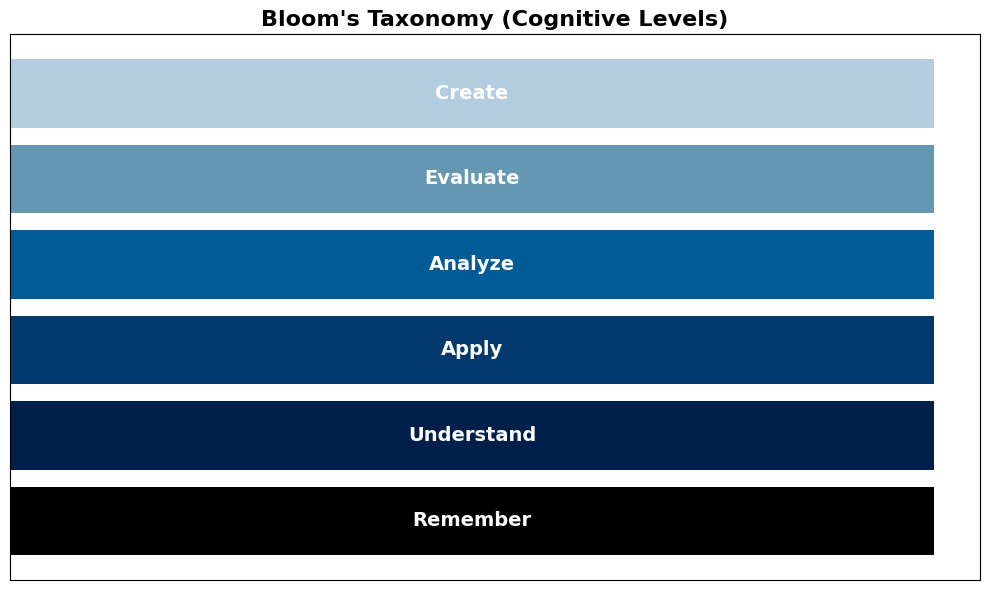


📚 Bloom's Taxonomy Explanation:
1. Remember: Recall facts and basic concepts
2. Understand: Explain ideas or concepts
3. Apply: Use information in new situations
4. Analyze: Draw connections among ideas
5. Evaluate: Justify a stand or decision
6. Create: Produce new or original work

------------------------------------------------------------
                         MAIN MENU
------------------------------------------------------------
1. Upload and Process Document
2. Take a Quiz (Short Answer)
3. Take Adaptive Quiz
4. Generate Questions on a Topic
5. Generate Multiple Choice Questions
6. Study Flashcards
7. Generate Flashcards
8. Visualize Bloom's Taxonomy
9. System Information
0. Exit

Enter your choice (0-9): 9

🧠 System Components:
- FAISS vector storage (in-memory)
- SentenceTransformer for embeddings
- LLaMA for question/answer generation
- Chunked document ingestion with overlap
- RAG-style semantic retrieval
- Short answer, MCQ, and adaptive quizzes
- Flashcard generator an

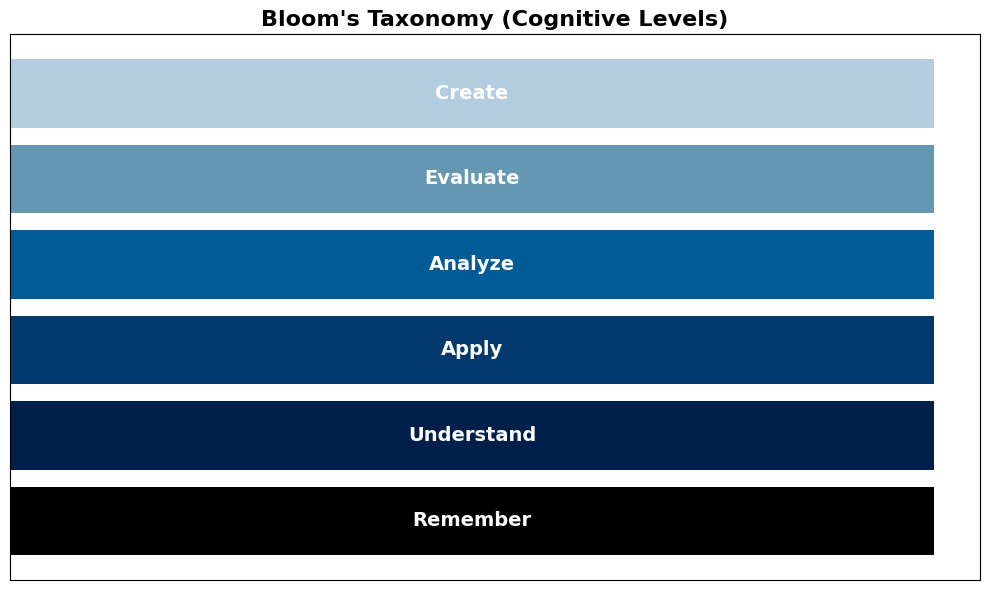


📚 Bloom's Taxonomy Explanation:
1. Remember: Recall facts and basic concepts
2. Understand: Explain ideas or concepts
3. Apply: Use information in new situations
4. Analyze: Draw connections among ideas
5. Evaluate: Justify a stand or decision
6. Create: Produce new or original work

------------------------------------------------------------
                         MAIN MENU
------------------------------------------------------------
1. Upload and Process Document
2. Take a Quiz (Short Answer)
3. Take Adaptive Quiz
4. Generate Questions on a Topic
5. Generate Multiple Choice Questions
6. Study Flashcards
7. Generate Flashcards
8. Visualize Bloom's Taxonomy
9. System Information
0. Exit

Enter your choice (0-9): 4
Enter topic: ml
Number of questions (default: 5): 2

[START] Generating Questions for topic: 'ml'
[INFO] Generating embedding for query: ml
[INFO] Query embedding generated successfully
[INFO] Searching for similar materials in DB
[INFO] Found 0 similar materials
[WARN] N

Llama.generate: prefix-match hit


 Done!

[INFO] LLM response received.
[COMPLETE] Generated 1 questions.

Q1. I will provide you with the correct answers once you have generated the questions.

------------------------------------------------------------
                         MAIN MENU
------------------------------------------------------------
1. Upload and Process Document
2. Take a Quiz (Short Answer)
3. Take Adaptive Quiz
4. Generate Questions on a Topic
5. Generate Multiple Choice Questions
6. Study Flashcards
7. Generate Flashcards
8. Visualize Bloom's Taxonomy
9. System Information
0. Exit

Enter your choice (0-9): 5
Enter topic: Data Science

[START] Generating MCQs for 'Data Science' (level 3)
How many multiple-choice questions to generate? (e.g., 3): 2
[INFO] Found 0 similar materials
[WARN] No relevant materials found for topic: Data Science
[INFO] Using default knowledge about the topic...
[INFO] Sending prompt to LLM...
Generating MCQs...

Llama.generate: prefix-match hit


 Done!
[WARN] LLM response does not contain proper MCQ format. Using fallback MCQs.
[INFO] LLM response received.
[COMPLETE] MCQs generated.

Multiple Choice Questions about Data Science:

Q1: What is the primary focus of Data Science?
A. Understanding key principles and concepts
B. Historical development only
C. Application without theory
D. Theoretical models only
Answer: A

Q2: Which of the following best describes Data Science?
A. A field of study with practical applications
B. An outdated concept
C. A purely theoretical construct
D. A recent invention with no history
Answer: A



------------------------------------------------------------
                         MAIN MENU
------------------------------------------------------------
1. Upload and Process Document
2. Take a Quiz (Short Answer)
3. Take Adaptive Quiz
4. Generate Questions on a Topic
5. Generate Multiple Choice Questions
6. Study Flashcards
7. Generate Flashcards
8. Visualize Bloom's Taxonomy
9. System Information
0.

In [ ]:
# Create and initialize the application
assistant = EnhancedLearningAssistant()
initialized = assistant.initialize()

# If initialization was successful, show the main menu
if initialized:
    assistant.main_menu()
else:
    print("❌ Failed to initialize the Learning Assistant. Please check the errors above.")

In [ ]:
 gsdEfficient Inference + High-Quality Generations
Optimized to achieve high output quality while maintaining fast inference speeds even on modest hardware (e.g., consumer GPUs, T4, A10G).
Uses advanced optimizations like:
Rotary positional embeddings (for better extrapolation over long sequences),
Better attention scaling techniques,Efficient Inference + High-Quality Generations
Optimized to achieve high output quality while maintaining fast inference speeds even on modest hardware (e.g., consumer GPUs, T4, A10G).
Uses advanced optimizations like:
Rotary positional embeddings (for better extrapolation over long sequences),
Better attention scaling techniques,   v